In [1]:
import glob 
import os
import pandas as pd
import statsmodels as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from importlib import reload
from sklearn import model_selection, metrics
from tqdm.auto import tqdm
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from src import main, feature_model

In [7]:
fp = np.random.choice(glob.glob('data/cis-pd/training_data/training_samples/*/*.csv'))
df = main.read_seq(fp)

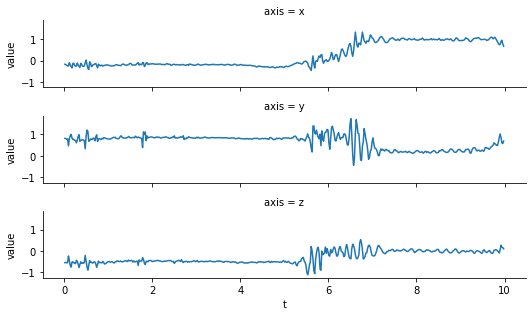

In [8]:
plot_df = df.reset_index().melt(value_vars=['x', 'y', 'z'], value_name='value', var_name='axis', id_vars='t')
grid = sns.relplot(data=plot_df, row='axis', x='t', y='value', kind='line', aspect=5, height=1.5)

In [34]:
labels1 = pd.read_csv('data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv')
labels2 = pd.read_csv('data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv')

In [11]:
import glob
import os
import pandas as pd

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

feature_vecs = []
model_order = (5, 1, 2)

for fp in tqdm(glob.glob('data/cis-pd/training_data/training_samples/*/*.csv')[:500]):
    samp_id = os.path.basename(os.path.dirname(fp))
    df = main.read_seq(fp)
    try:
        features = pd.concat([feature_model.extract_arima_features(df[axis], model_order=model_order) for axis in df])
        features['sample_id'] = samp_id
        feature_vecs.append(features)
    except: 
        continue

features_df = pd.DataFrame(feature_vecs)
features_df.to_csv('arima_features.csv')

In [39]:
label_cols = ['on_off', 'dyskinesia', 'tremor']

dataset = labels.merge(features_df, left_on='measurement_id', right_on='sample_id').drop(columns=['subject_id', 'sample_id', 'measurement_id']).dropna(axis='index')
# dataset[label_cols] = dataset[label_cols] / 4
training_set, test_set = model_selection.train_test_split(dataset, test_size=.2, stratify=dataset.on_off)

In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

def reluclip(x, max_value = 4):
    return K.relu(x, max_value = max_value)

def normed_difference(y_true, y_pred, yrange=4):
    return 1 - K.mean(K.abs(K.round(y_pred * yrange) - y_true)/yrange)

def accuracy(y_true, y_pred, round_scale=4):
    return K.round(y_pred * round_scale)

model = Sequential([
  Dense(16, activation='relu', input_shape=(3 * (model_order[0] + model_order[2]),)),
#   Dense(16, activation='relu'),
  Dense(3, activation=reluclip),
])

model.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=[normed_difference, ],
)

train_data = training_set.drop(columns=label_cols)
train_labels = training_set[label_cols]
test_data = test_set.drop(columns=label_cols)
test_labels = test_set[label_cols]

hist = model.fit(
  train_data,
  train_labels,
  epochs=300,
  batch_size=64,
  validation_data=(test_data, test_labels)
)

Train on 179 samples, validate on 45 samples
Epoch 1/300
179/179 [==============================] - 0s 2ms/step - loss: 3.2226 - normed_difference: 0.6656 - val_loss: 2.6844 - val_normed_difference: 0.6907
Epoch 2/300
179/179 [==============================] - 0s 110us/step - loss: 3.1805 - normed_difference: 0.6628 - val_loss: 2.6505 - val_normed_difference: 0.6889
Epoch 3/300
179/179 [==============================] - 0s 62us/step - loss: 3.1327 - normed_difference: 0.6609 - val_loss: 2.6157 - val_normed_difference: 0.6796
Epoch 4/300
179/179 [==============================] - 0s 89us/step - loss: 3.0863 - normed_difference: 0.6579 - val_loss: 2.5819 - val_normed_difference: 0.6630
Epoch 5/300
179/179 [==============================] - 0s 53us/step - loss: 3.0392 - normed_difference: 0.6482 - val_loss: 2.5453 - val_normed_difference: 0.6463
Epoch 6/300
179/179 [==============================] - 0s 54us/step - loss: 3.0001 - normed_difference: 0.6392 - val_loss: 2.5064 - val_normed_di

179/179 [==============================] - 0s 29us/step - loss: 1.8739 - normed_difference: 0.2212 - val_loss: 1.7822 - val_normed_difference: 0.1704
Epoch 52/300
179/179 [==============================] - 0s 33us/step - loss: 1.8581 - normed_difference: 0.2042 - val_loss: 1.7716 - val_normed_difference: 0.1704
Epoch 53/300
179/179 [==============================] - 0s 29us/step - loss: 1.8395 - normed_difference: 0.2031 - val_loss: 1.7610 - val_normed_difference: 0.1648
Epoch 54/300
179/179 [==============================] - 0s 33us/step - loss: 1.8250 - normed_difference: 0.2020 - val_loss: 1.7504 - val_normed_difference: 0.1556
Epoch 55/300
179/179 [==============================] - 0s 29us/step - loss: 1.8060 - normed_difference: 0.1985 - val_loss: 1.7409 - val_normed_difference: 0.1444
Epoch 56/300
179/179 [==============================] - 0s 33us/step - loss: 1.7903 - normed_difference: 0.1872 - val_loss: 1.7323 - val_normed_difference: 0.1352
Epoch 57/300
179/179 [=============

Epoch 101/300
179/179 [==============================] - 0s 44us/step - loss: 1.4179 - normed_difference: 0.0193 - val_loss: 1.5978 - val_normed_difference: -0.0370
Epoch 102/300
179/179 [==============================] - 0s 69us/step - loss: 1.4139 - normed_difference: 0.0199 - val_loss: 1.5971 - val_normed_difference: -0.0370
Epoch 103/300
179/179 [==============================] - 0s 46us/step - loss: 1.4108 - normed_difference: 0.0174 - val_loss: 1.5968 - val_normed_difference: -0.0370
Epoch 104/300
179/179 [==============================] - 0s 71us/step - loss: 1.4075 - normed_difference: 0.0177 - val_loss: 1.5971 - val_normed_difference: -0.0407
Epoch 105/300
179/179 [==============================] - 0s 44us/step - loss: 1.4042 - normed_difference: 0.0118 - val_loss: 1.5970 - val_normed_difference: -0.0463
Epoch 106/300
179/179 [==============================] - 0s 71us/step - loss: 1.4015 - normed_difference: 0.0140 - val_loss: 1.5955 - val_normed_difference: -0.0519
Epoch 107/

179/179 [==============================] - 0s 42us/step - loss: 1.1877 - normed_difference: -0.0459 - val_loss: 1.5635 - val_normed_difference: -0.0815
Epoch 200/300
179/179 [==============================] - 0s 69us/step - loss: 1.1859 - normed_difference: -0.0428 - val_loss: 1.5626 - val_normed_difference: -0.0815
Epoch 201/300
179/179 [==============================] - 0s 43us/step - loss: 1.1842 - normed_difference: -0.0466 - val_loss: 1.5616 - val_normed_difference: -0.0759
Epoch 202/300
179/179 [==============================] - 0s 69us/step - loss: 1.1827 - normed_difference: -0.0444 - val_loss: 1.5607 - val_normed_difference: -0.0759
Epoch 203/300
179/179 [==============================] - 0s 43us/step - loss: 1.1810 - normed_difference: -0.0398 - val_loss: 1.5604 - val_normed_difference: -0.0741
Epoch 204/300
179/179 [==============================] - 0s 70us/step - loss: 1.1793 - normed_difference: -0.0430 - val_loss: 1.5607 - val_normed_difference: -0.0741
Epoch 205/300
179/

Epoch 297/300
179/179 [==============================] - 0s 31us/step - loss: 1.0345 - normed_difference: -0.0480 - val_loss: 1.5388 - val_normed_difference: -0.0574
Epoch 298/300
179/179 [==============================] - 0s 31us/step - loss: 1.0327 - normed_difference: -0.0546 - val_loss: 1.5384 - val_normed_difference: -0.0556
Epoch 299/300
179/179 [==============================] - 0s 31us/step - loss: 1.0316 - normed_difference: -0.0481 - val_loss: 1.5387 - val_normed_difference: -0.0574
Epoch 300/300
179/179 [==============================] - 0s 31us/step - loss: 1.0300 - normed_difference: -0.0467 - val_loss: 1.5386 - val_normed_difference: -0.0593


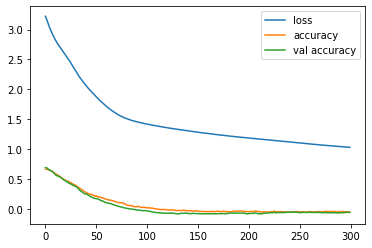

In [62]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['normed_difference'], label='accuracy')
plt.plot(hist.history['val_normed_difference'], label='val accuracy')
plt.legend()

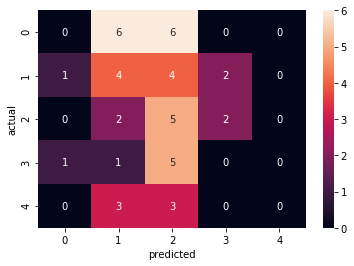

In [64]:
pred = np.around(model.predict(test_data)[:, 0])
actual = np.around(test_labels.values[:, 0])
 
confusion_m = pd.DataFrame(metrics.confusion_matrix(actual, pred))
confusion_m.index.name = 'actual'
confusion_m.columns.name = 'predicted'
sns.heatmap(confusion_m, annot=True)

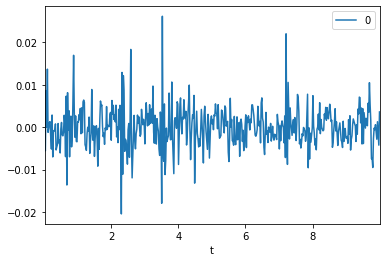

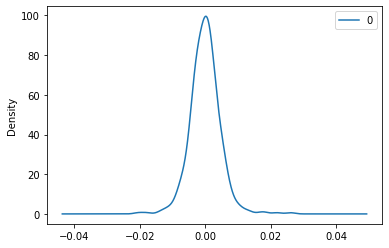

                0
count  499.000000
mean    -0.000002
std      0.004642
min     -0.020433
25%     -0.002761
50%      0.000006
75%      0.002485
max      0.026124


In [105]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [106]:
model_fit.params

ar.L1.D.x    1.629741
ar.L2.D.x   -0.892714
ar.L3.D.x   -0.066262
ar.L4.D.x   -0.033986
ar.L5.D.x    0.057510
ma.L1.D.x   -1.617317
ma.L2.D.x    0.940893
dtype: float64

In [62]:
train, test = list(df.x[:1182].values), list(df.x[1182:].values)
model_order = (5, 1, 2)

model = ARIMA(train, order=model_order)
model_fit = model.fit(disp=0)

predicted, actual = [], []
for unobserved in tqdm(test):
    model = ARIMA(train + actual, order=model_order)
    model_fit = model.fit(disp=0)
    
    predicted.append(model_fit.forecast()[0])
    actual.append(unobserved)

/home/hy180/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


/home/hy180/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/hy180/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/hy180/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/hy180/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/hy180/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/hy180/anaco

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

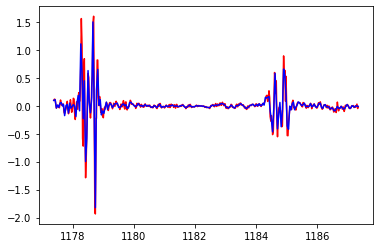

In [51]:
# Downsampling fidelity test
df_down = signal.decimate(df.x, q=2)

plt.plot(df.index, df.x, color='r')
plt.plot(df.index[::2], df_down, color='b')